In [103]:
import matplotlib
matplotlib.use('AGG')

In [78]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

In [2]:
### LOAD DATA ###
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [113]:
def circular(g, ax=None):
    if ax is None:
        ax = plt.gca()
    
    colors = np.array(['#808080']*y_test.shape[0])
    colors[y_test == 1] = '#FF0000'
    g.vs['color'] = colors.tolist()
    
    layout = g.layout_circle(order=np.argsort(y_test.reset_index()['status']).values)
    ig.plot(g, layout=layout, target=ax, vertex_color=g.vs['color'])


def mds(g, ax=None):
    if ax is None:
        ax = plt.gca()

    layout = g.layout_mds()
    ig.plot(g, layout=layout, target=ax, vertex_color=g.vs['color'], edge_width=.1)
    
    return layout

In [4]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic/models/RandomForestClassifier.pkl',
                './results/Basic/models/XGBClassifier.pkl',
                './results/Basic/models/LogisticRegression.pkl',
                './results/Basic/models/LinearDiscriminantAnalysis.pkl']

In [6]:
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    print(model_name)

best_xgb
RandomForestClassifier
XGBClassifier
LogisticRegression
LinearDiscriminantAnalysis


In [7]:
model = models_paths[0]
model_folder = '/'.join(model.split('/')[:-1])
model_name = model.split('/')[-1].split('.')[0]
results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
results = results[0:4] # Only 4 smallest graphs
model_results = joblib.load(model)

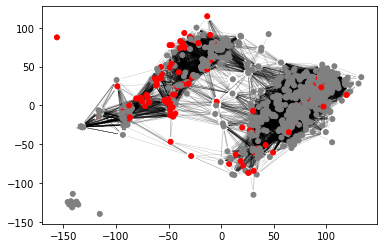

In [116]:
graph = results[2][3]

# Color by failure to predict
y_pred = model_results['y_pred']
failed = y_test != y_pred
colors = np.array(['#808080']*y_test.shape[0])
colors[failed == 1] = '#FF0000'
graph.vs['color'] = colors.tolist()

# Subgraph by random sampling
new_vs = np.random.choice(range(3009), 1000, replace=False)
sample_vs = graph.vs.select(new_vs)
sample_graph = graph.subgraph(sample_vs)

layout = mds(sample_graph)
plt.savefig('averss.png', bbox_inches='tight', dpi=300, transparent=True)

In [66]:
# Varias categorias
import colorcet as cc
unique_cats = [0,1,2,3]
dic = {cat:cc.glasbey[i] for i, cat in enumerate(unique_cats)}

a = pd.Series([0,1,1,2,3,])
a.replace(dic)

In [75]:
def get_plot(result, colored='fail'):
    fig, ax = plt.subplots(figsize=(20, 20))
    
    graph = result[3]
    
    if colored=='fail':
        y_pred = model_results['y_pred']
        cats = y_test != y_pred
    elif colored=='pred':
        cats = y_pred
    elif colored=='true':
        cats = y_test
    else:
        raise Exception('{} is not a suported colored'.format(colored))
    
    # Prepare Graph
    colors = np.array(['#808080']*cats.shape[0])
    colors[cats == 1] = '#FF0000'
    graph.vs['color'] = colors.tolist()
    new_vs = np.random.choice(range(3009), 1000, replace=False)
    sample_vs = graph.vs.select(new_vs)
    sample_graph = graph.subgraph(sample_vs)
    
    mds(sample_graph, ax=None)

    fig_name = '{}-{:.0f}-mds'.format(model_name, result[0]*10)
    fig_path = './results/figures/graphs/{}'.format(fig_name)
    plt.savefig(fig_path+'.png', bbox_inches='tight', dpi=300, transparent=True)
    plt.savefig(fig_path+'.svg', bbox_inches='tight', transparent=True)
    plt.show()

for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
    results = results[0:4] # Only 4 smallest graphs
    
    Parallel(n_jobs=4)(delayed(tmp_plot)(result) for result in results)

Figure(2000x2000)
Figure(2000x2000)
Figure(2000x2000)
Figure(2000x2000)
Figure(2000x2000)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}